In [1]:
import polars as pl
import plotnine as p9
import torch
import lifetimes
from pathlib import Path

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arviz.labels import MapLabeller

from pymc_marketing import clv
from pymc_marketing.prior import Prior


In [3]:
pl.Config.set_tbl_width_chars(-1)
pl.Config.set_tbl_rows(100)


polars.config.Config

# Load Data

In [4]:
files = ["search_query",
"page_visit",
 "add_to_cart",
 "remove_from_cart",
 "product_properties",
 "product_buy",
]

In [5]:
pwd

'/home/sean/projects/recsys2025'

In [6]:
def get_preprocessed_files(files: list[str]):
    dfs = {}
    for file in files:
        orig_file = f"data/ubc/{file}.parquet"
        preprocessed_file = f"data/ubc_typed/{file}.parquet"
        if Path(preprocessed_file).exists():
            df = pl.read_parquet(preprocessed_file)
        else:
            df = pl.read_parquet(orig_file)
            df = preprocess(df)
            df.write_parquet(preprocessed_file)
        dfs[file] = df
    return dfs


def preprocess(df: pl.DataFrame)-> pl.DataFrame:
    if "timestamp" in df.schema and not(isinstance(df.schema["timestamp"],pl.Datetime)):
        df = df.with_columns(pl.col("timestamp").str.to_datetime(time_unit="ms"))
    if "query" in df.schema:
        df = list_int(df, "query")
    if "name" in df.schema:
        df = list_int(df, "name")
    return df

def list_int(df:pl.DataFrame,column:str):
    """ take string column of form "[ <int_1><spaces><int>...<int_16>]" and convert into list of int 16s."""
    df = (
        df.with_columns(
            pl.col(column).str.replace_all(" {2,}"," ")
            .str.strip_chars("[] ")
            .str.split(" ")
            .cast(pl.List(pl.Int16))
        )
    )
    return df


def get_client_start_dates(df:pl.DataFrame):
    client_start_dates = df.group_by("client_id").agg(pl.col("timestamp").min())
    return client_start_dates

In [7]:
dfs = get_preprocessed_files(files)

In [8]:
df1 = get_client_start_dates(dfs["product_buy"])

In [9]:
df1.head()

client_id,timestamp
i64,datetime[ms]
620151,2022-07-10 08:41:35
22164728,2022-09-25 11:35:55
2328521,2022-08-04 19:56:15
12582522,2022-06-09 07:02:05
11004048,2022-06-10 21:34:35


In [10]:
df1.n_unique()

750860

In [11]:
dfs["product_buy"].columns

['client_id', 'timestamp', 'sku']

In [13]:
dfs["product_buy"].select(pl.all().n_unique())

client_id,timestamp,sku
u32,u32,u32
750860,827453,507107


In [8]:
dfs["product_buy"].group_by("client_id").agg(pl.col("timestamp").n_unique()).describe()

statistic,client_id,timestamp
str,f64,f64
"""count""",750860.0,750860.0
"""null_count""",0.0,0.0
"""mean""",1.1940e7,1.468747
"""std""",6.8857e6,1.480217
"""min""",14.0,1.0
"""25%""",5.979306e6,1.0
"""50%""",1.1934371e7,1.0
"""75%""",1.7895368e7,1.0
"""max""",2.3875234e7,423.0


In [12]:
# dont join until have done all preprocessing on the data

buy = dfs["product_buy"].with_columns(action=pl.lit("product_buy")).join(dfs["product_properties"], on="sku", how="left")
add_to_cart = dfs["add_to_cart"].with_columns(action=pl.lit("add_to_cart")).join(dfs["product_properties"], on="sku", how="left")

In [9]:
dfs["page_visit"].max()

client_id,timestamp,url
i64,datetime[ms],i64
23875259,2022-10-10 23:59:59,15869648


In [10]:
dfs["product_buy"].select(pl.col("timestamp").max().dt.truncate("2w").dt.offset_by("2w"))

timestamp
datetime[ms]
2022-10-17 00:00:00


# Price Histogram
price is a quantile

(and therefore ) price relatively uniform

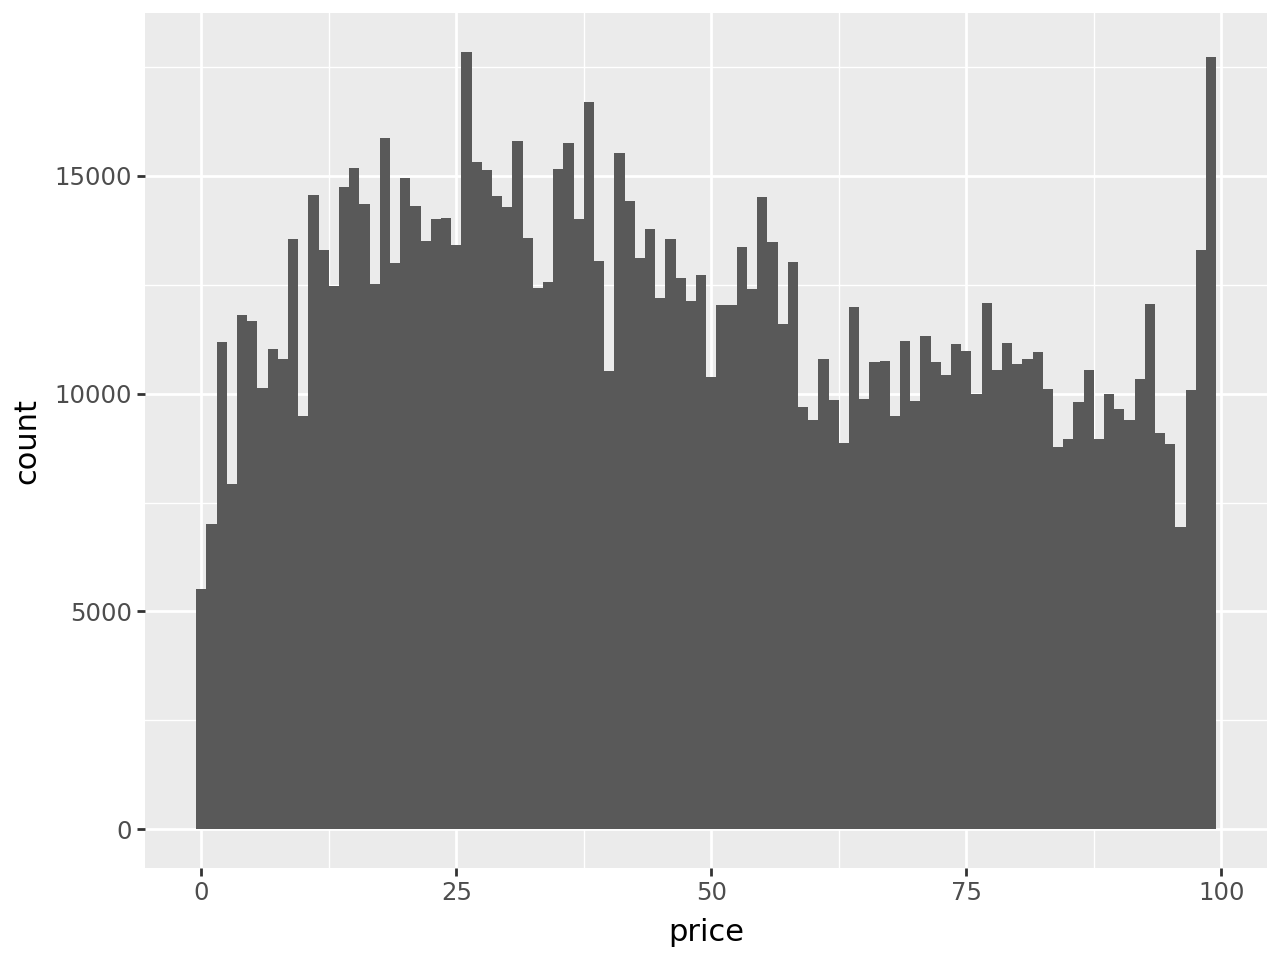

In [12]:
p9.ggplot(dfs["product_properties"],p9.aes(x="price")) + p9.geom_histogram(bins=100)

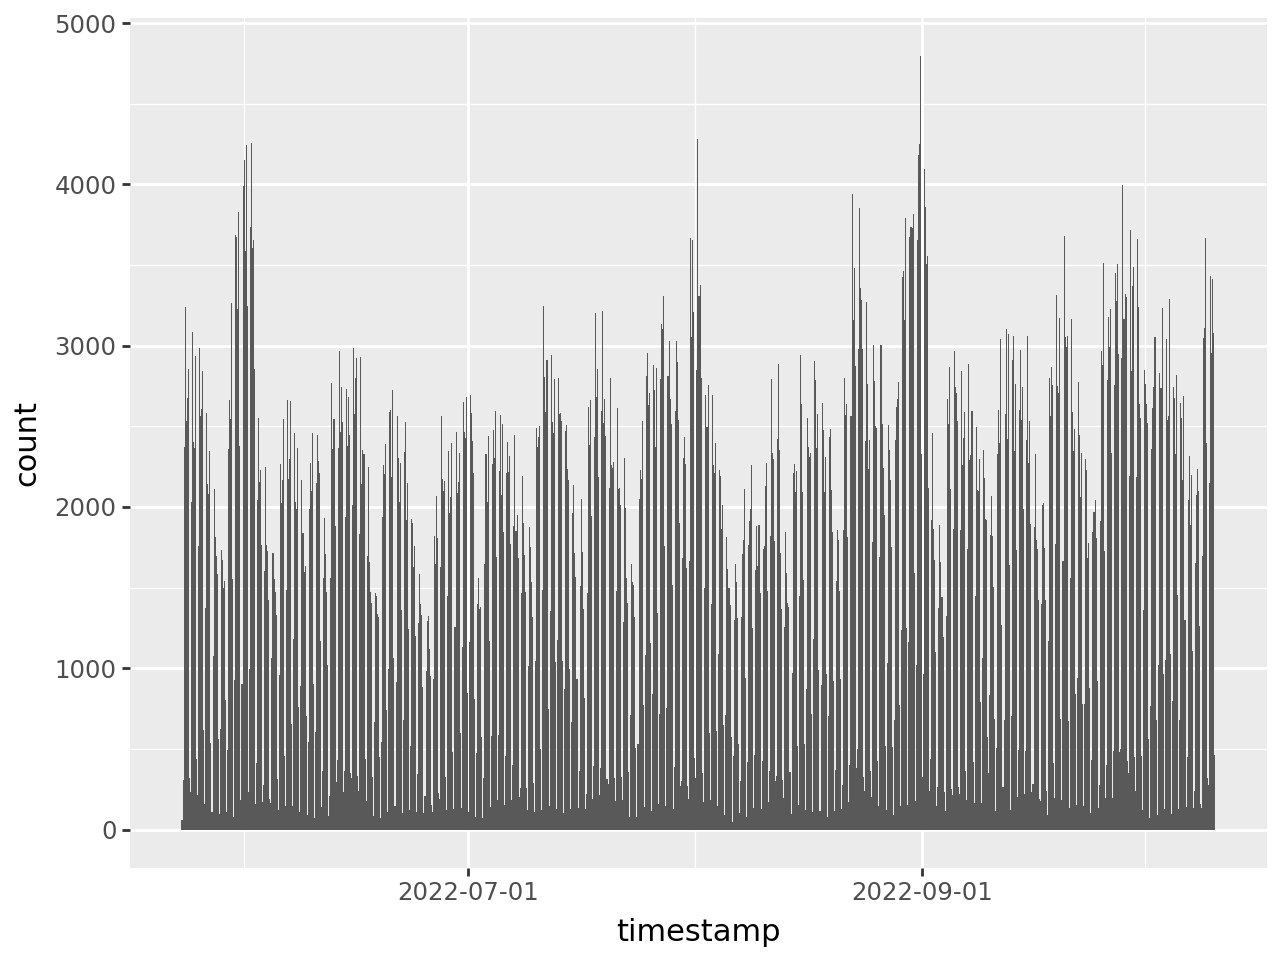

In [9]:
p9.ggplot(dfs["product_buy"],p9.aes(x="timestamp")) + p9.geom_histogram(bins=1000)

timestamp relatively uniform

In [11]:
buy.describe()

statistic,client_id,timestamp,sku,action,category,price,name
str,f64,str,f64,str,f64,f64,f64
"""count""",1.682296e6,"""1682296""",1.682296e6,"""1682296""",1.682296e6,1.682296e6,1.682296e6
"""null_count""",0.0,"""0""",0.0,"""0""",0.0,0.0,0.0
"""mean""",1.1941e7,"""2022-08-03 16:59:32.528000""",746549.671699,null,3547.154632,51.303007,null
"""std""",6.8918e6,null,433618.826745,null,1916.609451,27.211957,null
"""min""",14.0,"""2022-05-23 00:10:40""",4.0,"""product_buy""",0.0,0.0,null
"""25%""",5.964836e6,"""2022-06-29 09:17:00""",369890.0,null,1946.0,29.0,null
"""50%""",1.1924383e7,"""2022-08-04 06:37:45""",745837.0,null,3509.0,53.0,null
"""75%""",1.791873e7,"""2022-09-08 09:56:50""",1.121913e6,null,5197.0,74.0,null
"""max""",2.3875234e7,"""2022-10-10 23:59:25""",1.495777e6,"""product_buy""",6918.0,99.0,null


# Customer lifetime value
https://juanitorduz.github.io/html/berlin_bayesians_btyd.html#/purchase-metrics
Age
Recency
Frequency
Monetary Value

frequency: Number of repeat purchases the customer has made. More precisely, It’s the count of time periods the customer had a purchase in.

T: Age of the customer in whatever time units chosen. This is equal to the duration between a customer’s first purchase and the end of the period under study.

recency: Age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase.

buy.with_columns(age=pl.col("date).wee

#group_by("

In [19]:
buy.select(pl.all().n_unique())

client_id,timestamp,sku,action,category,price,name
u32,u32,u32,u32,u32,u32,u32
750860,827453,507107,1,6089,100,409517


In [15]:
rfm_data = clv.utils.rfm_summary(
    buy.to_pandas(),
    customer_id_col="client_id",
    datetime_col="timestamp",
    monetary_value_col="price",
    time_unit="W",
)

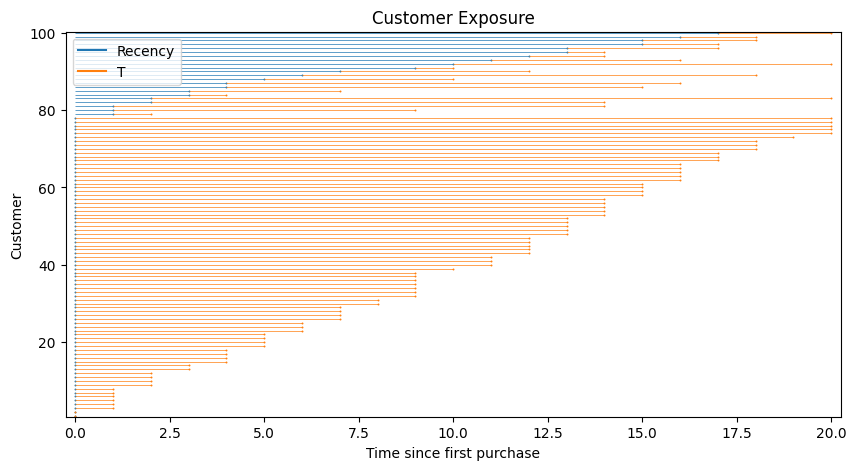

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
(
    rfm_data.sample(n=100, random_state=42)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);


Only 20% had more than 1 purchase.

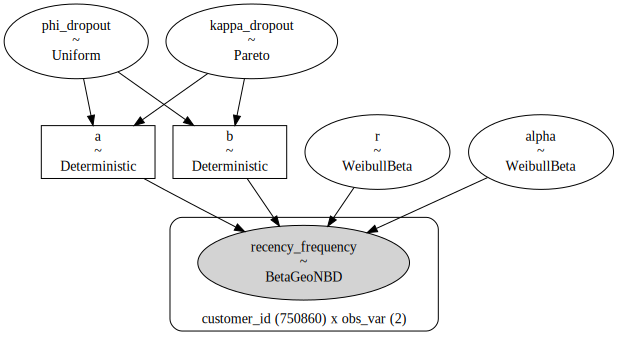

In [19]:
bgm = clv.BetaGeoModel(data=rfm_data)

bgm.build_model()
bgm.graphviz()

In [ ]:
bgm.fit()
bgm.fit_summary()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, phi_dropout, kappa_dropout, r]


Output()

/home/sean/projects/recsys2025/.venv/lib/python3.12/site-packages/pytensor/scalar/basic.py:3191: RuntimeWarning: overflow encountered in exp
/home/sean/projects/recsys2025/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
/home/sean/projects/recsys2025/.venv/lib/python3.12/site-packages/pytensor/scalar/basic.py:2094: RuntimeWarning: invalid value encountered in divide
/home/sean/projects/recsys2025/.venv/lib/python3.12/site-packages/pytensor/scalar/basic.py:2052: RuntimeWarning: invalid value encountered in scalar subtract
/home/sean/projects/recsys2025/.venv/lib/python3.12/site-packages/pytensor/scalar/basic.py:3191: RuntimeWarning: overflow encountered in exp
/home/sean/projects/recsys2025/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
/home/sean/projects/recsys2025/.venv/lib/python3.12/site-packages/pytensor/scalar/basic.py:2094: RuntimeWarning: 

# Client Stats

1.7 million purchases, 
750,000 clients, 500,000 items, 409000 names 6089 categories.
5 months of purchases

In [20]:
client_buy_stats = (
    buy
    .group_by("client_id", "price")
    .agg(
        pl.col("price").count().alias("sales_count"),
        pl.col("sku").n_unique().alias("skus"),
        pl.col("category").n_unique().alias("categories"),
        pl.col("timestamp").dt.week().n_unique().alias("frequency"),
        ((buy["timestamp"].max() - pl.col("timestamp").min())/pl.duration(days=7)).alias("T"),
        ((pl.col("timestamp").max() - pl.col("timestamp").min())/pl.duration(days=7)).alias("recency"),
    )
    .with_columns(client_sales_count=pl.col("sales_count").sum().over("client_id"))
)

In [21]:
client_buy_stats.head()

client_id,price,sales_count,skus,categories,frequency,T,recency,client_sales_count
i64,i64,u32,u32,u32,u32,f64,f64,u32
17657902,41,2,1,1,1,18.76727,0.0,4
4491480,28,1,1,1,1,4.474454,0.0,4
7953671,58,2,1,1,1,18.472586,0.0,4
21587697,84,2,1,1,1,2.092923,0.0,4
1962960,41,1,1,1,1,18.027778,0.0,2


In [41]:
sales_count = (
    client_buy_stats
    .group_by("client_sales_count","price")
    .agg(pl.col("sales_count").sum())
    .with_columns(sales_count_prop=pl.col("sales_count")/pl.col("sales_count").sum().over("price"))
    .sort("price","client_sales_count")
)
sales_count.head()

client_sales_count,price,sales_count,sales_count_prop
u32,i64,u32,f64
1,0,750,0.06697
2,0,1039,0.092776
3,0,563,0.050272
4,0,552,0.04929
5,0,464,0.041432


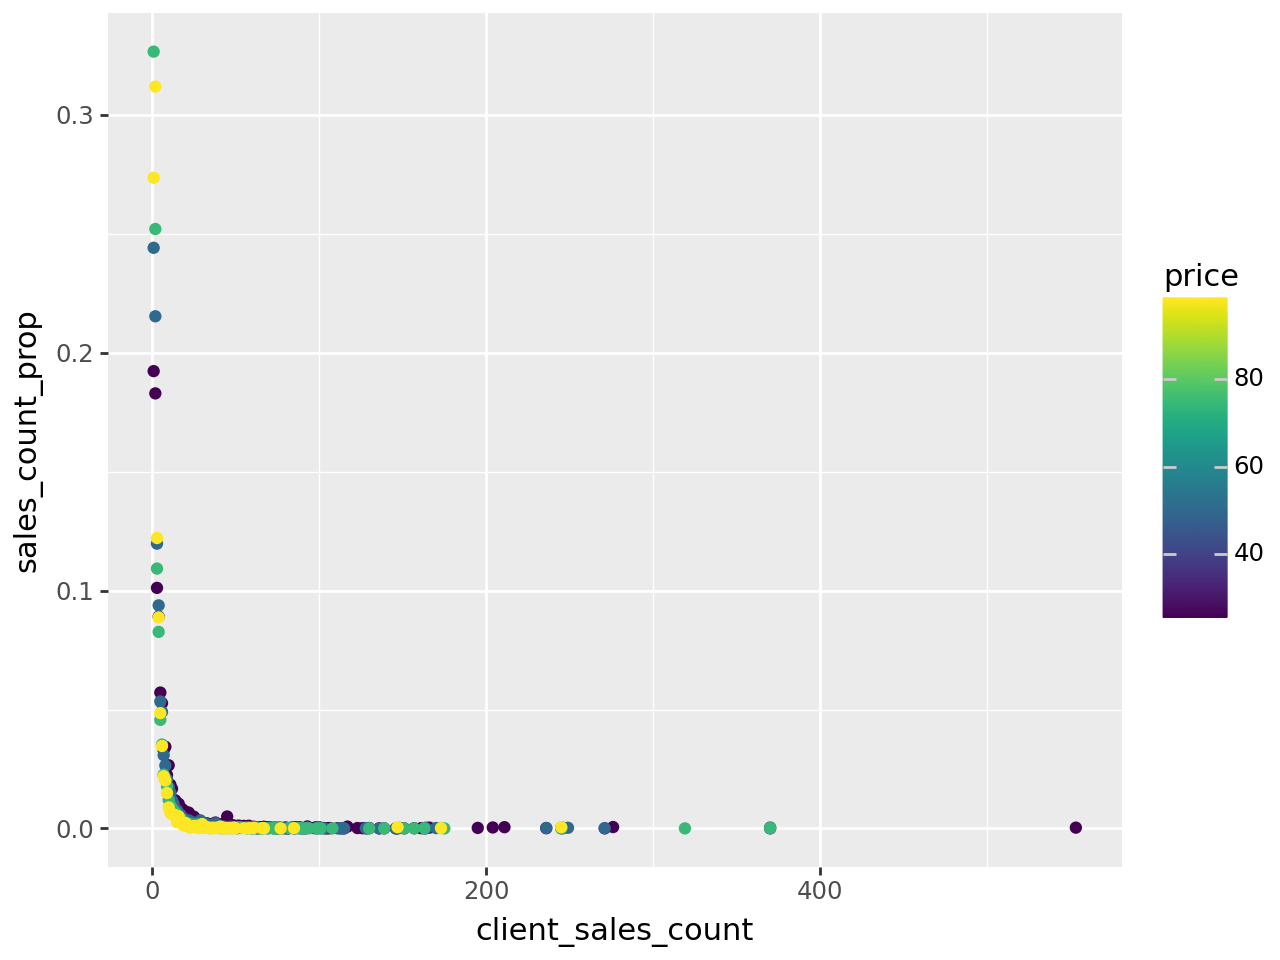

In [42]:
plot_data = sales_count.filter(pl.col("price").is_in([25, 50, 75,99]))
p9.ggplot(plot_data, p9.aes(x="client_sales_count", y="sales_count_prop",color="price")) + p9.geom_point()

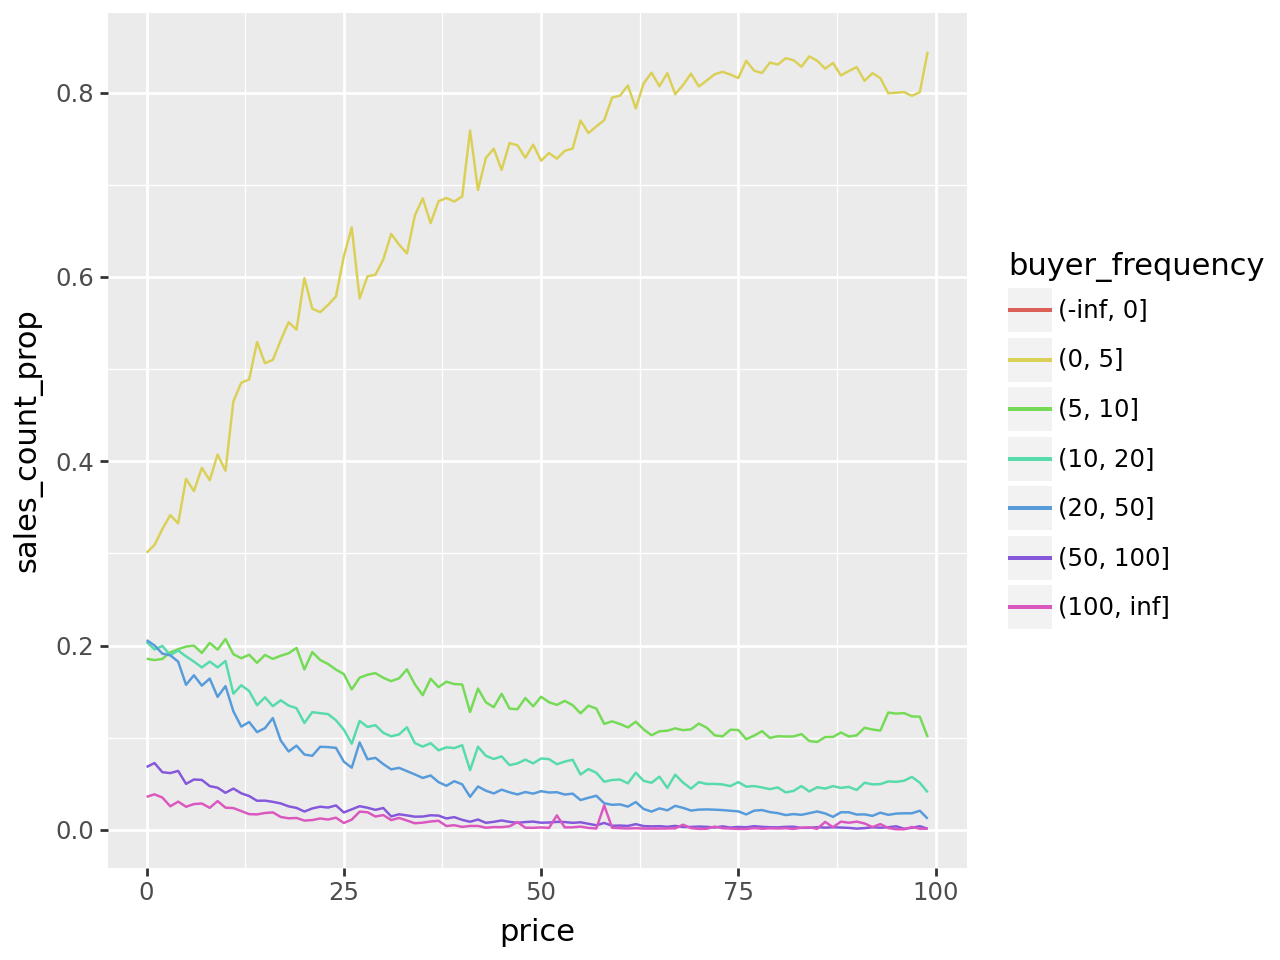

In [54]:
plot_data = sales_count.with_columns(pl.col("client_sales_count").cut([0,5,10,20,50, 100]).alias("buyer_frequency")).group_by("buyer_frequency", "price").sum()
p9.ggplot(plot_data,p9.aes(x="price", y="sales_count_prop",colour="buyer_frequency"))+p9.geom_line()

At the bottom pricepoint, customers with 5 items or less cover 30% of sales, 
at 50 percentile, 75%
and at the highest pricepoint it is closer to 85%

In [24]:
client_buy_stats.head()

client_id,price,sales_count,skus,categories,frequency,T,recency,client_sales_count
i64,i64,u32,u32,u32,u32,f64,f64,u32
17657902,41,2,1,1,1,18.76727,0.0,4
4491480,28,1,1,1,1,4.474454,0.0,4
7953671,58,2,1,1,1,18.472586,0.0,4
21587697,84,2,1,1,1,2.092923,0.0,4
1962960,41,1,1,1,1,18.027778,0.0,2


In [ ]:
client_buy_stats.group_by("sales_count").agg(

In [10]:
buy["timestamp"].max() 

datetime.datetime(2022, 10, 10, 23, 59, 25)

In [11]:
client_buy_stats.describe(percentiles=[0.01,.1,.25,.5,.75,.9,.99])

statistic,client_id,sales_count,price_mean,sales_value,skus,categories,frequency,T,recency
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",750860.0,750860.0,750860.0,750860.0,750860.0,750860.0,750860.0,750860.0,750860.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.1940e7,2.240492,56.779341,114.943988,1.813888,1.555587,1.289124,10.732599,1.313058
"""std""",6.8857e6,3.713613,23.699825,154.342931,2.742158,1.718789,0.794742,5.93064,3.542372
"""min""",14.0,1.0,0.0,0.0,1.0,1.0,1.0,0.000008,0.0
…,…,…,…,…,…,…,…,…,…
"""50%""",1.1934371e7,1.0,59.0,80.0,1.0,1.0,1.0,11.079299,0.0
"""75%""",1.7895368e7,2.0,76.0,137.0,2.0,2.0,1.0,16.054621,0.0
"""90%""",2.1485738e7,4.0,88.0,219.0,3.0,3.0,2.0,18.750107,5.33025


90% of clients had no more than 4 sales and 3 distinct skus.
most were active for only 37 days

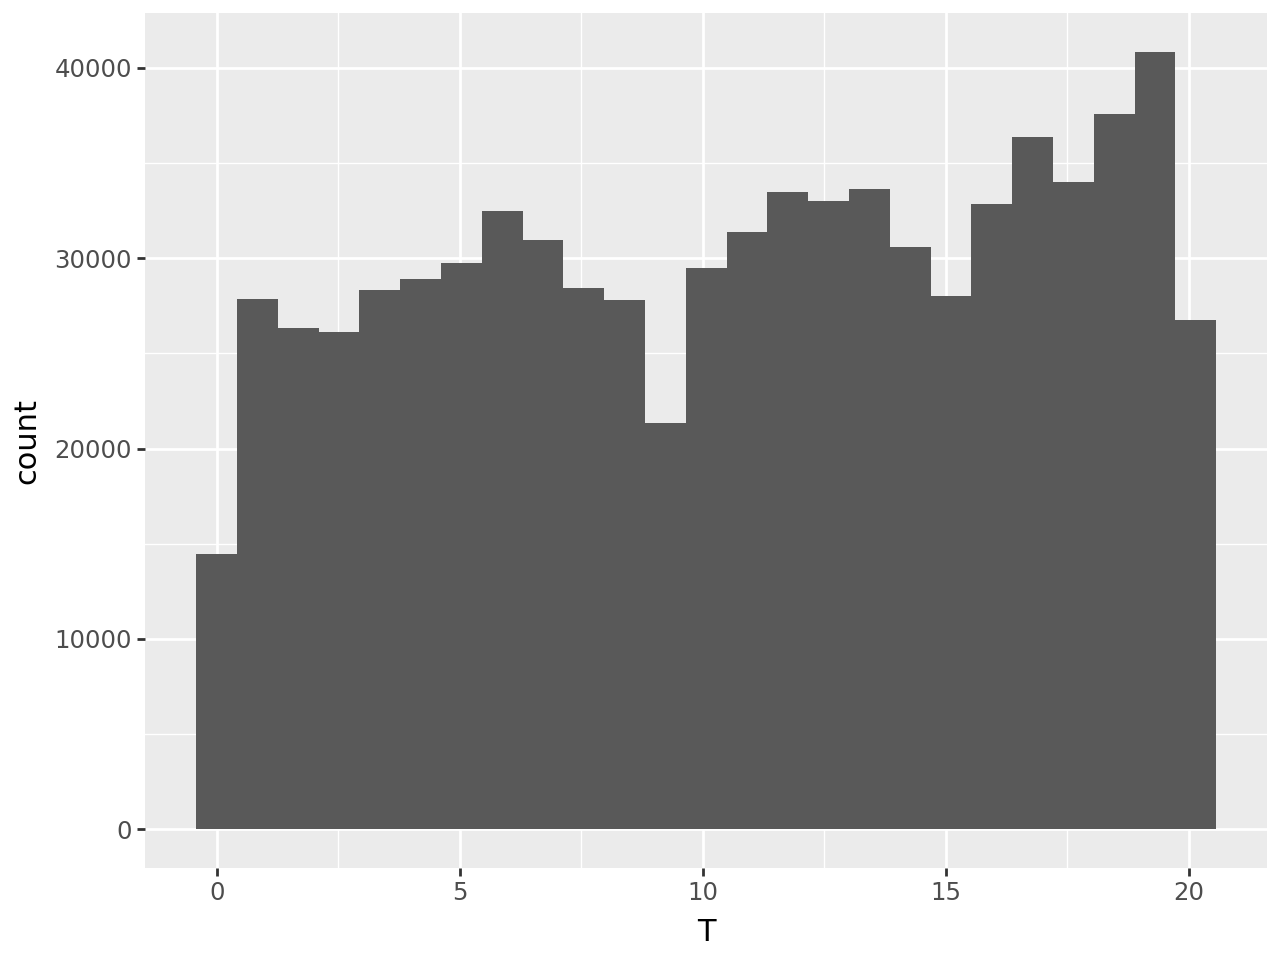

In [16]:
p9.ggplot(client_buy_stats,p9.aes(x="T")) + p9.geom_histogram(bins=25)

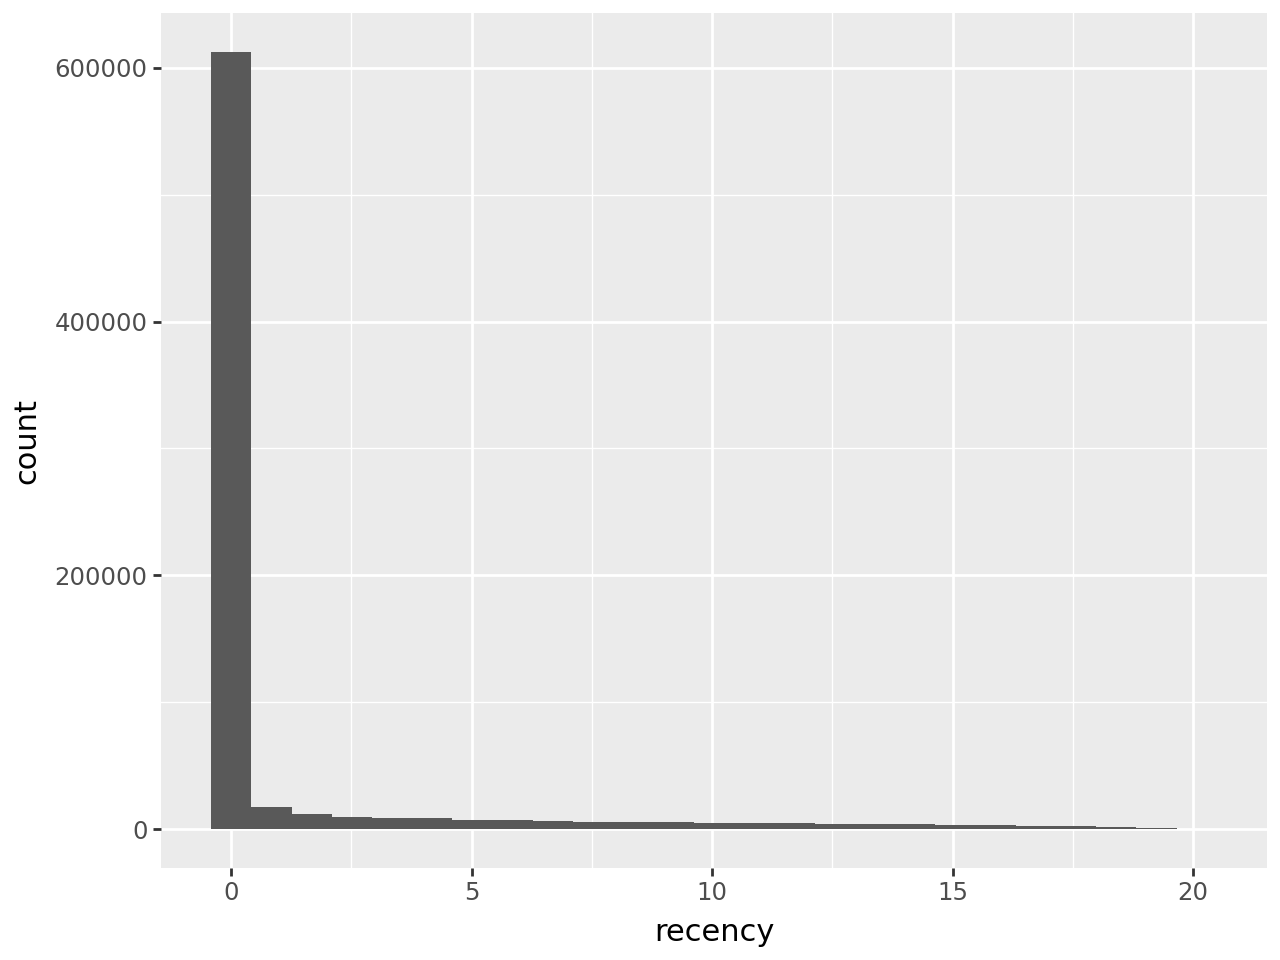

In [19]:
p9.ggplot(client_buy_stats,p9.aes(x="recency")) + p9.geom_histogram(bins=25)

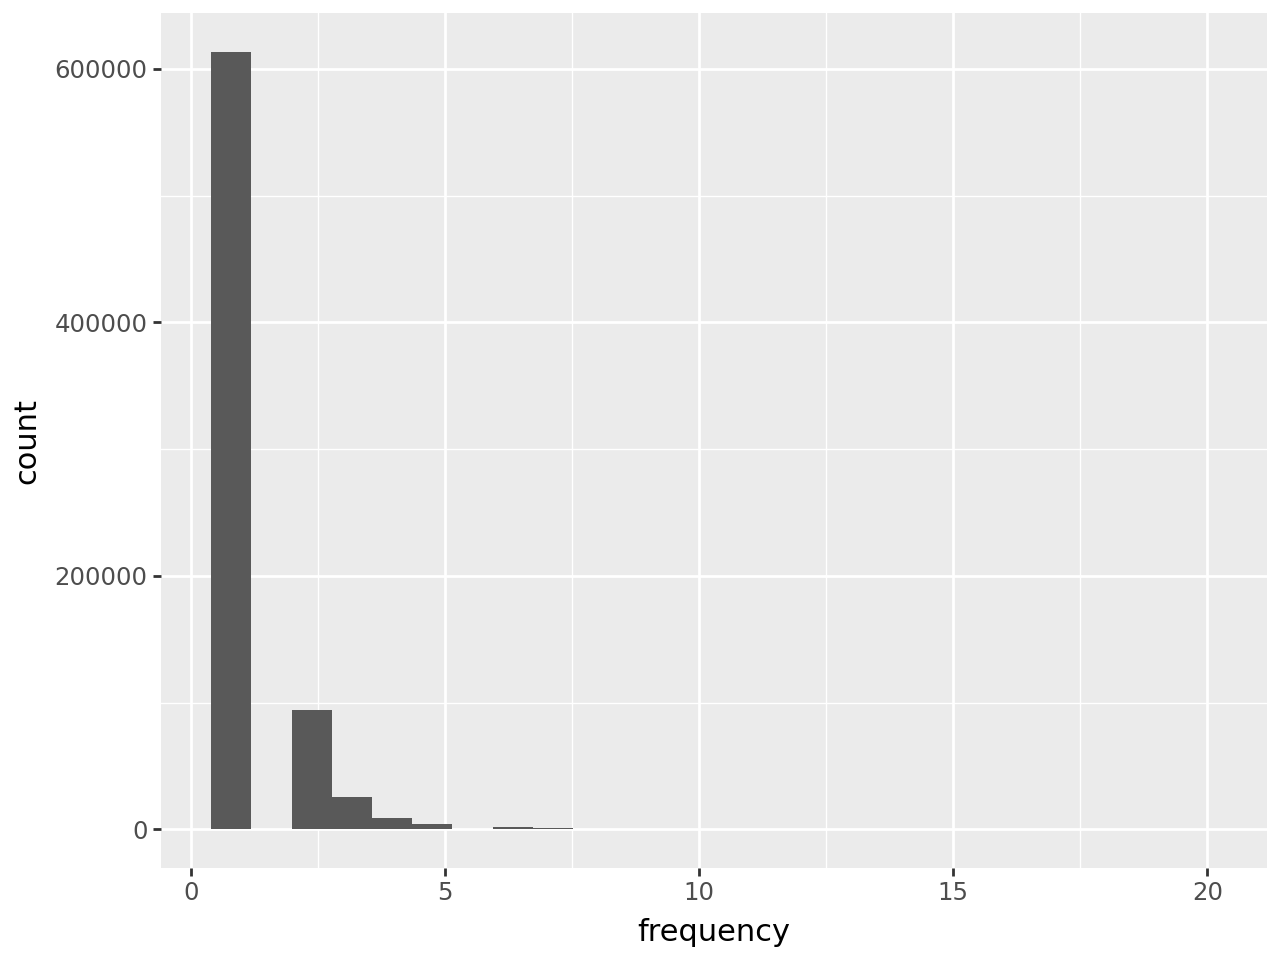

In [15]:
p9.ggplot(client_buy_stats,p9.aes(x="frequency")) + p9.geom_histogram(bins=25)

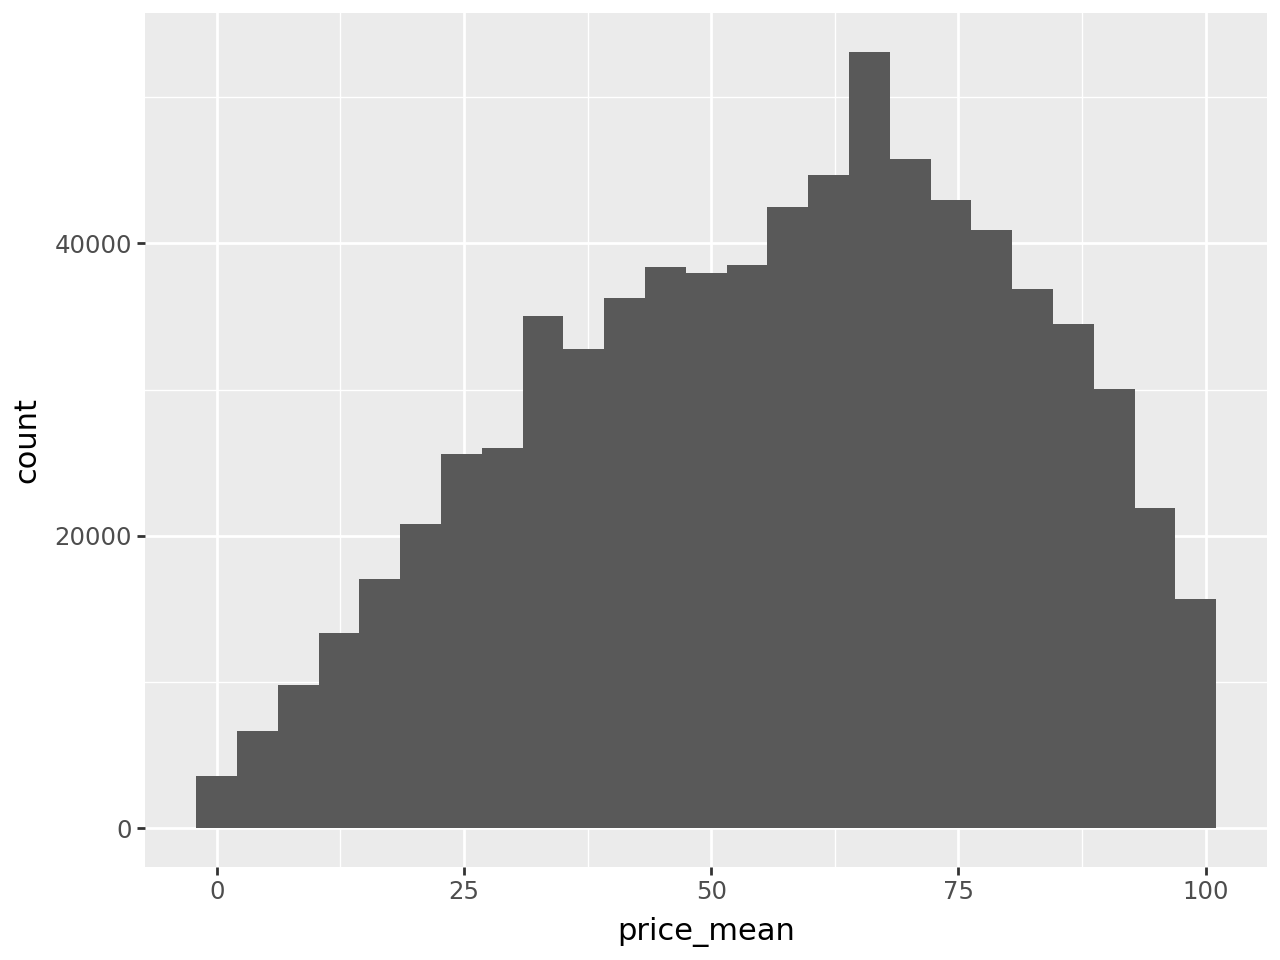

In [18]:
p9.ggplot(client_buy_stats,p9.aes(x="price_mean")) + p9.geom_histogram(bins=25)

In [28]:
buy["sku"].n_unique()

58336

In [16]:
skus = (
    buy["sku"].value_counts(sort=True)
    .with_columns(cum_count=pl.col("count").cum_sum())
    .with_columns(cum_freq=pl.col("cum_count")/pl.col("cum_count").tail(1))
)


In [18]:
categories = (
    buy["category"].value_counts(sort=True)
    .with_columns(cum_count=pl.col("count").cum_sum())
    .with_columns(cum_freq=pl.col("cum_count")/pl.col("cum_count").tail(1))
)

In [44]:
skus.shape

(58336, 4)

In [17]:
skus.head()

sku,count,cum_count,cum_freq
i64,u32,u32,f64
1061794,1249,1249,0.000742
1068071,1111,2360,0.001403
1466277,1080,3440,0.002045
1420323,1049,4489,0.002668
1326077,1034,5523,0.003283


In [43]:
skus[40000]

sku,count,cum_count,cum_freq
i64,u32,u32,f64
1373834,1,81665,0.81665


500,000 skus 
40,000 skus capture 82% of sales


In [19]:
categories.head()

category,count,cum_count,cum_freq
i64,u32,u32,f64
3068,42128,42128,0.025042
5954,26241,68369,0.04064
3147,19400,87769,0.052172
3944,18054,105823,0.062904
2739,13619,119442,0.070999


In [25]:
categories.shape

(6089, 4)

In [24]:
categories[1000]

category,count,cum_count,cum_freq
i64,u32,u32,f64
6412,324,1390330,0.826448


In [68]:
product = pl.concat((buy,add_to_cart))

In [69]:
product.shape

(2000000, 7)

In [70]:
product.filter(pl.col("client_id")==4708463).sort("timestamp")

client_id,timestamp,sku,action,category,price,name
i64,datetime[ms],i64,str,i64,i64,str
4708463,2022-07-20 02:56:30,237442,"""add_to_cart""",2079,69,"""[230 124 223 77 226 148 132 1…"
4708463,2022-07-20 02:59:45,237442,"""product_buy""",2079,69,"""[230 124 223 77 226 148 132 1…"


In [71]:
product.filter(pl.col("sku")==237442).sort("client_id","timestamp")

client_id,timestamp,sku,action,category,price,name
i64,datetime[ms],i64,str,i64,i64,str
33711,2022-07-20 07:51:55,237442,"""product_buy""",2079,69,"""[230 124 223 77 226 148 132 1…"
178501,2022-07-19 13:40:55,237442,"""add_to_cart""",2079,69,"""[230 124 223 77 226 148 132 1…"
178501,2022-07-19 13:45:55,237442,"""product_buy""",2079,69,"""[230 124 223 77 226 148 132 1…"
257153,2022-07-20 19:38:05,237442,"""add_to_cart""",2079,69,"""[230 124 223 77 226 148 132 1…"
257153,2022-07-20 19:57:15,237442,"""add_to_cart""",2079,69,"""[230 124 223 77 226 148 132 1…"
…,…,…,…,…,…,…
23668014,2022-08-22 04:25:05,237442,"""product_buy""",2079,69,"""[230 124 223 77 226 148 132 1…"
23668014,2022-08-22 04:35:35,237442,"""add_to_cart""",2079,69,"""[230 124 223 77 226 148 132 1…"
23732846,2022-07-19 12:58:50,237442,"""product_buy""",2079,69,"""[230 124 223 77 226 148 132 1…"


In [72]:
product.filter(pl.col("client_id")==23732846).sort("timestamp")

client_id,timestamp,sku,action,category,price,name
i64,datetime[ms],i64,str,i64,i64,str
23732846,2022-07-19 12:58:50,237442,"""product_buy""",2079,69,"""[230 124 223 77 226 148 132 1…"


In [25]:
buy.group_by("client_id").agg(pl.len()).get_column("len").describe(percentiles=[.01,.10,.25,.50,.6,.7,.75,.90,.95,.96,.97,.98,.99])

statistic,value
str,f64
"""count""",750860.0
"""null_count""",0.0
"""mean""",2.240492
"""std""",3.713613
"""min""",1.0
"""1%""",1.0
"""10%""",1.0
"""25%""",1.0
"""50%""",1.0


50% have only 1 purchase, 75% have 2, 90% 4 and 98% have 10

In [26]:
buy.filter(pl.col("client_id")==13684077)

client_id,timestamp,sku,action,category,price,name
i64,datetime[ms],i64,str,i64,i64,list[i16]
13684077,2022-09-08 21:42:55,436878,"""product_buy""",1517,36,"[100, 109, … 252]"
13684077,2022-09-08 21:42:55,39041,"""product_buy""",1374,86,"[121, 65, … 140]"
13684077,2022-09-08 21:42:55,814355,"""product_buy""",1374,88,"[209, 26, … 9]"
13684077,2022-09-08 21:42:55,774895,"""product_buy""",139,36,"[15, 6, … 56]"
13684077,2022-09-08 21:42:55,1478935,"""product_buy""",831,80,"[152, 21, … 72]"
13684077,2022-09-08 21:42:55,403318,"""product_buy""",1374,58,"[209, 54, … 72]"
13684077,2022-09-08 21:42:55,972561,"""product_buy""",680,0,"[209, 235, … 72]"
13684077,2022-09-08 21:42:55,601476,"""product_buy""",2910,42,"[180, 109, … 72]"
13684077,2022-09-08 21:42:55,630911,"""product_buy""",1374,68,"[234, 81, … 9]"


# Training Data
Having taken the split data,
generate sliding window
block_size=4
for each client id
get history

a b c d e

a : b
a b: c
a b c: d


groupby client_id
get length and create list


for ix in 0:len(history) - block_size:block_size
    x = history[ix:ix + block_size]
    y = history[ix :ix + block_size + 1]
    for t in 1:block_size + 1
    context = x[:t]
    target = y[t + 1]




In [27]:
buy.head()

client_id,timestamp,sku,action,category,price,name
i64,datetime[ms],i64,str,i64,i64,list[i16]
17649961,2022-07-23 20:15:25,18485,"""product_buy""",5492,72,"[187, 47, … 224]"
16696114,2022-07-11 16:31:30,81192,"""product_buy""",6519,99,"[241, 241, … 241]"
10238779,2022-05-29 19:35:40,510014,"""product_buy""",6350,58,"[167, 24, … 32]"
10238779,2022-05-29 19:38:05,510014,"""product_buy""",6350,58,"[167, 24, … 32]"
10238779,2022-05-29 19:38:05,510014,"""product_buy""",6350,58,"[167, 24, … 32]"


In [9]:
buy.describe()

statistic,client_id,timestamp,sku,action,category,price,name
str,f64,str,f64,str,f64,f64,f64
"""count""",1.682296e6,"""1682296""",1.682296e6,"""1682296""",1.682296e6,1.682296e6,1.682296e6
"""null_count""",0.0,"""0""",0.0,"""0""",0.0,0.0,0.0
"""mean""",1.1941e7,"""2022-08-03 16:59:32.528000""",746549.671699,null,3547.154632,51.303007,null
"""std""",6.8918e6,null,433618.826745,null,1916.609451,27.211957,null
"""min""",14.0,"""2022-05-23 00:10:40""",4.0,"""product_buy""",0.0,0.0,null
"""25%""",5.964836e6,"""2022-06-29 09:17:00""",369890.0,null,1946.0,29.0,null
"""50%""",1.1924383e7,"""2022-08-04 06:37:45""",745837.0,null,3509.0,53.0,null
"""75%""",1.791873e7,"""2022-09-08 09:56:50""",1.121913e6,null,5197.0,74.0,null
"""max""",2.3875234e7,"""2022-10-10 23:59:25""",1.495777e6,"""product_buy""",6918.0,99.0,null


Purchase dates from 2022-05-23 to 2025-10-11
convert to weekly and group by sku

In [12]:

buy.head()

client_id,timestamp,sku,action,category,price,name,week2
i64,datetime[ms],i64,str,i64,i64,list[i16],datetime[ms]
17649961,2022-07-23 20:15:25,18485,"""product_buy""",5492,72,"[187, 47, … 224]",2022-07-11 00:00:00
16696114,2022-07-11 16:31:30,81192,"""product_buy""",6519,99,"[241, 241, … 241]",2022-07-11 00:00:00
10238779,2022-05-29 19:35:40,510014,"""product_buy""",6350,58,"[167, 24, … 32]",2022-05-16 00:00:00
10238779,2022-05-29 19:38:05,510014,"""product_buy""",6350,58,"[167, 24, … 32]",2022-05-16 00:00:00
10238779,2022-05-29 19:38:05,510014,"""product_buy""",6350,58,"[167, 24, … 32]",2022-05-16 00:00:00


client_id,week2,sku,category,name,price,n_skus,price_sum
i64,datetime[ms],i64,i64,list[i16],i64,u32,i64
2470169,2022-06-27 00:00:00,1424397,3263,"[221, 221, … 221]",22,2,44
2610880,2022-05-30 00:00:00,389733,5730,"[164, 149, … 41]",66,1,66
16316258,2022-08-22 00:00:00,774188,6393,"[169, 141, … 2]",15,2,30
1373309,2022-07-11 00:00:00,600655,2085,"[19, 249, … 42]",79,1,79
14216892,2022-10-03 00:00:00,683607,572,"[37, 69, … 5]",83,1,83


In [25]:
# confirm only single sku per client week
(buy_client_2weekly_sku_single.group_by(["client_id","week2"]).len()==1).get_column("len").all()

True

In [37]:
#last date in 2 week schedule
dfs["product_buy"].select(pl.col("timestamp").max().dt.truncate("2w").dt.offset_by("2w"))

timestamp
datetime[ms]
2022-10-17 00:00:00


In [22]:
buy_client_2weekly_sku.filter(pl.col("client_id")==6324435)

client_id,week2,sku,category,name,price,n_skus,price_sum
i64,datetime[ms],i64,i64,list[i16],i64,u32,i64
6324435,2022-05-30 00:00:00,165491,2047,"[186, 55, … 186]",55,2,110


group by client
order by date n_skus 
add shifted sku - lag 1 .. 4

In [30]:
buy_client_2weekly_lags_extend.head()

client_id,week2,sku,category,name,price,n_skus,price_sum,sku_lag_1,category_lag_1,name_lag_1,price_lag_1,n_skus_lag_1,price_sum_lag_1,timestamp
i64,datetime[ms],i64,i64,list[i16],i64,u32,i64,i64,i64,list[i16],i64,u32,i64,datetime[ms]
14,2022-06-13 00:00:00,1104211,2405,"[203, 167, … 195]",54,1,54,null,null,null,null,null,null,null
28,2022-09-05 00:00:00,471059,827,"[118, 22, … 118]",78,1,78,null,null,null,null,null,null,null
36,2022-09-19 00:00:00,1068071,3709,"[72, 138, … 123]",64,1,64,null,null,null,null,null,null,null
54,2022-07-11 00:00:00,507271,4628,"[236, 47, … 231]",36,2,72,null,null,null,null,null,null,null
54,2022-09-05 00:00:00,958259,1051,"[237, 14, … 14]",52,1,52,507271,4628,"[236, 47, … 231]",36,2,72,null


## Buy Client 2 weekly

In [12]:
def get_week_col(n_weeks):
    return f"week{n_weeks}"

def get_week_col_df(df:pl.DataFrame):
    week_col = [c for c in df.columns if c.startswith("week")][0]
    return week_col

def add_week_col(df:pl.DataFrame, n_weeks:int=1):
    week_col = get_week_col(n_weeks)
    df = df.with_columns(pl.col("timestamp").dt.truncate(f"{n_weeks}w").alias(week_col))
    return df


def discretise_to_weeks(df:pl.DataFrame):
    week_col = get_week_col_df(df)
    df = (
        df
        .group_by("client_id",week_col,"sku")
        .agg(pl.len().alias("count"))
    )
    return df

def create_client_end_date(df: pl.DataFrame)->pl.DataFrame:
    # only works for 2 week interval
    clients = df.select("client_id").unique()
    df_end_date = clients.with_columns(week2=pl.datetime(2022,10,17,0,0,time_unit="ms"))
    return df_end_date


def drop_multiple_skus(df):
    week_col = get_week_col_df(df)
    df = (
        df
        .group_by(["client_id",week_col])
        .agg(pl.all().top_k_by("price_sum",k=1))
        .explode(pl.all().exclude(["client_id",week_col]))
    )
    return df




def add_lags(df: pl.DataFrame, n_lags: int):
    week_col = get_week_col_df(df)
    lags = [pl.all().exclude("client_id",week_col).shift(1).over("client_id").name.suffix("_lag_{i_lag+1}") for i_lag in range(n_lags)]
    df = (
        df
        .sort("client_id",week_col)
        .with_columns(lags)
    )
    return df

    
def create_discretised_buy(df):
    n_weeks = 2
    df_pb = add_week_col(df,n_weeks)
    df_pb_2w = discretise_to_weeks(df_pb)
    client_end_dates = create_client_end_date(df_pb_2w)
    df_pb_2w_end= pl.concat((df_pb_2w,client_end_dates),how="diagonal")
    return df_pb_2w_end

def upsample_weeks(df):
    df_align= df.sort("client_id","week2").upsample(time_column="week2",every="2w",group_by=["client_id"])
    df_align_fill = df_align.with_columns(
        pl.col("client_id").fill_null(strategy="forward"),
        pl.col("sku").fill_null(0),
        pl.col("count").fill_null(0))
    
    return df_align_fill

In [13]:
df_pb = add_week_col(dfs["product_buy"],2)
df_pb_2w = discretise_to_weeks(df_pb)
client_end_dates = create_client_end_date(df_pb_2w)
df_pb_2w_end= pl.concat((df_pb_2w,client_end_dates),how="diagonal")
df_pb_2w.head()
client_end_dates.head()

client_id,week2
i64,datetime[ms]
18055358,2022-10-17 00:00:00
14682667,2022-10-17 00:00:00
19512171,2022-10-17 00:00:00
17962806,2022-10-17 00:00:00
17781284,2022-10-17 00:00:00


In [15]:
df_pb_hist=create_discretised_buy(dfs["product_buy"])

In [18]:
df_pb_2w.group_by("client_id").agg(pl.col("week2").n_unique()).describe()


statistic,client_id,week2
str,f64,f64
"""count""",750860.0,750860.0
"""null_count""",0.0,0.0
"""mean""",1.1940e7,1.252176
"""std""",6.8857e6,0.683817
"""min""",14.0,1.0
"""25%""",5.979306e6,1.0
"""50%""",1.1934371e7,1.0
"""75%""",1.7895368e7,1.0
"""max""",2.3875234e7,11.0


In [24]:
# how many date do customers buy on?
zz = df_pb_hist.group_by(pl.col("client_id")).agg(pl.col("week2").n_unique())

In [31]:
(
    zz
    .get_column("week2")
    .value_counts(sort=True)
    .with_columns(freq=pl.col("count")/pl.col("count").sum())
    .with_columns(cum_freq=pl.col("freq").cum_sum((),cum_freq_desc=pl.col("freq").cum_sum())
                 )

week2,count,freq,cum_freq
u32,u32,f64,f64
2,622946,0.829643,0.829643
3,90921,0.121089,0.950732
4,23173,0.030862,0.981594
5,7999,0.010653,0.992248
6,3162,0.004211,0.996459
7,1394,0.001857,0.998315
8,706,0.00094,0.999256
9,339,0.000451,0.999707
10,140,0.000186,0.999893


83% of clients only appear in 1 2 week period, 12% in 2 and 3% in 3
17% churn after 1 week,


In [32]:
df_pb_hist.describe()

statistic,client_id,week2,sku,count
str,f64,str,f64,f64
"""count""",2.133359e6,"""2133359""",1.382499e6,1.382499e6
"""null_count""",0.0,"""0""",750860.0,750860.0
"""mean""",1.1945e7,"""2022-08-25 08:13:57.664000""",746619.218322,1.216852
"""std""",6.8891e6,null,433606.530979,0.579051
"""min""",14.0,"""2022-05-16 00:00:00""",4.0,1.0
"""25%""",5.974686e6,"""2022-07-11 00:00:00""",369852.0,1.0
"""50%""",1.1934908e7,"""2022-09-05 00:00:00""",745901.0,1.0
"""75%""",1.7914249e7,"""2022-10-17 00:00:00""",1.121914e6,1.0
"""max""",2.3875234e7,"""2022-10-17 00:00:00""",1.495777e6,253.0


5 months of data, so 10 2 week periods
so could do attention up to 10 weeks


In [16]:
df_pb_hist_upsample = upsample_weeks(df_pb_hist)

In [14]:
df_pb_hist.filter(pl.col("client_id")==14121227)

client_id,week2,sku,count
i64,datetime[ms],i64,u32
14121227,2022-08-22 00:00:00,1356466,2
14121227,2022-10-03 00:00:00,892331,1
14121227,2022-10-03 00:00:00,1234560,1
14121227,2022-10-17 00:00:00,null,null


In [13]:
df_pb_hist_upsample.filter(pl.col("client_id")==14121227)

week2,client_id,sku,count
datetime[ms],i64,i64,u32
2022-08-22 00:00:00,14121227,1356466,2
2022-09-05 00:00:00,14121227,0,0
2022-09-19 00:00:00,14121227,0,0
2022-10-03 00:00:00,14121227,892331,1
2022-10-03 00:00:00,14121227,1234560,1
2022-10-17 00:00:00,14121227,0,0


In [ ]:
df_train = df_pb_hist.group_by(["client_id","week2"]).agg(pl.col("sku").n_unique()).group_by()
df_train.head()

client_id,week2,sku
i64,datetime[ms],u32
12637008,2022-10-17 00:00:00,1
22874308,2022-10-17 00:00:00,1
20505086,2022-10-17 00:00:00,1
4318081,2022-05-30 00:00:00,1
4591583,2022-06-13 00:00:00,2


In [46]:
df_pb_2w_end.head()

client_id,week2,sku,count
i64,datetime[ms],i64,u32
14121227,2022-10-03 00:00:00,892331,1
22679983,2022-08-08 00:00:00,377991,1
16067321,2022-06-27 00:00:00,1391318,1
942170,2022-10-03 00:00:00,72572,1
19701621,2022-08-22 00:00:00,454167,2


In [21]:

df_pb_2w_end.filter(pl.col("client_id")==14121227)

client_id,week2,sku,count
i64,datetime[ms],i64,u32
14121227,2022-10-03 00:00:00,892331,1
14121227,2022-10-03 00:00:00,1234560,1
14121227,2022-08-22 00:00:00,1356466,2
14121227,2022-10-17 00:00:00,null,null


# Process

1. create lags of 10 weeks
2. join metadata
   - category
   - price
3. generate lags
4. 


# old processing

In [17]:
buy_client_2weekly = (
def 
    buy
    .group_by("client_id","week2")
    .agg(pl.len())
    .sort("client_id","week2")
    .with_columns(week2_p1=pl.col("week2").shift().over("client_id"))
    .with_columns(week_diff= (pl.col("week2") - pl.col("week2_p1"))/pl.duration(weeks=1))
)


buy_client_2weekly_sku.head()


client_id,week2,len,week2_p1,week_diff
i64,datetime[ms],u32,datetime[ms],f64
14,2022-06-13 00:00:00,2,null,null
28,2022-09-05 00:00:00,1,null,null
36,2022-09-19 00:00:00,1,null,null
54,2022-07-11 00:00:00,8,null,null
54,2022-09-05 00:00:00,1,2022-07-11 00:00:00,8.0
…,…,…,…,…
392,2022-05-30 00:00:00,1,null,null
468,2022-08-22 00:00:00,2,null,null
480,2022-08-08 00:00:00,2,null,null


In [22]:
buy_client_2weekly.describe(percentiles = [0.01,0.1,.2,.3,.4,.5,.6,.7,.8,.9,.99])

statistic,client_id,week2,len,week2_p1,week_diff
str,f64,str,f64,str,f64
"""count""",940209.0,"""940209""",940209.0,"""189349""",189349.0
"""null_count""",0.0,"""0""",0.0,"""750860""",750860.0
"""mean""",1.1945e7,"""2022-07-25 22:08:05.914000""",1.789279,"""2022-07-08 14:52:05.390000""",5.239573
"""std""",6.8886e6,null,2.247907,null,3.891879
"""min""",14.0,"""2022-05-16 00:00:00""",1.0,"""2022-05-16 00:00:00""",2.0
"""1%""",242575.0,"""2022-05-16 00:00:00""",1.0,"""2022-05-16 00:00:00""",2.0
"""10%""",2.400914e6,"""2022-05-30 00:00:00""",1.0,"""2022-05-30 00:00:00""",2.0
"""20%""",4.784676e6,"""2022-06-13 00:00:00""",1.0,"""2022-05-30 00:00:00""",2.0
"""30%""",7.180166e6,"""2022-06-27 00:00:00""",1.0,"""2022-06-13 00:00:00""",2.0


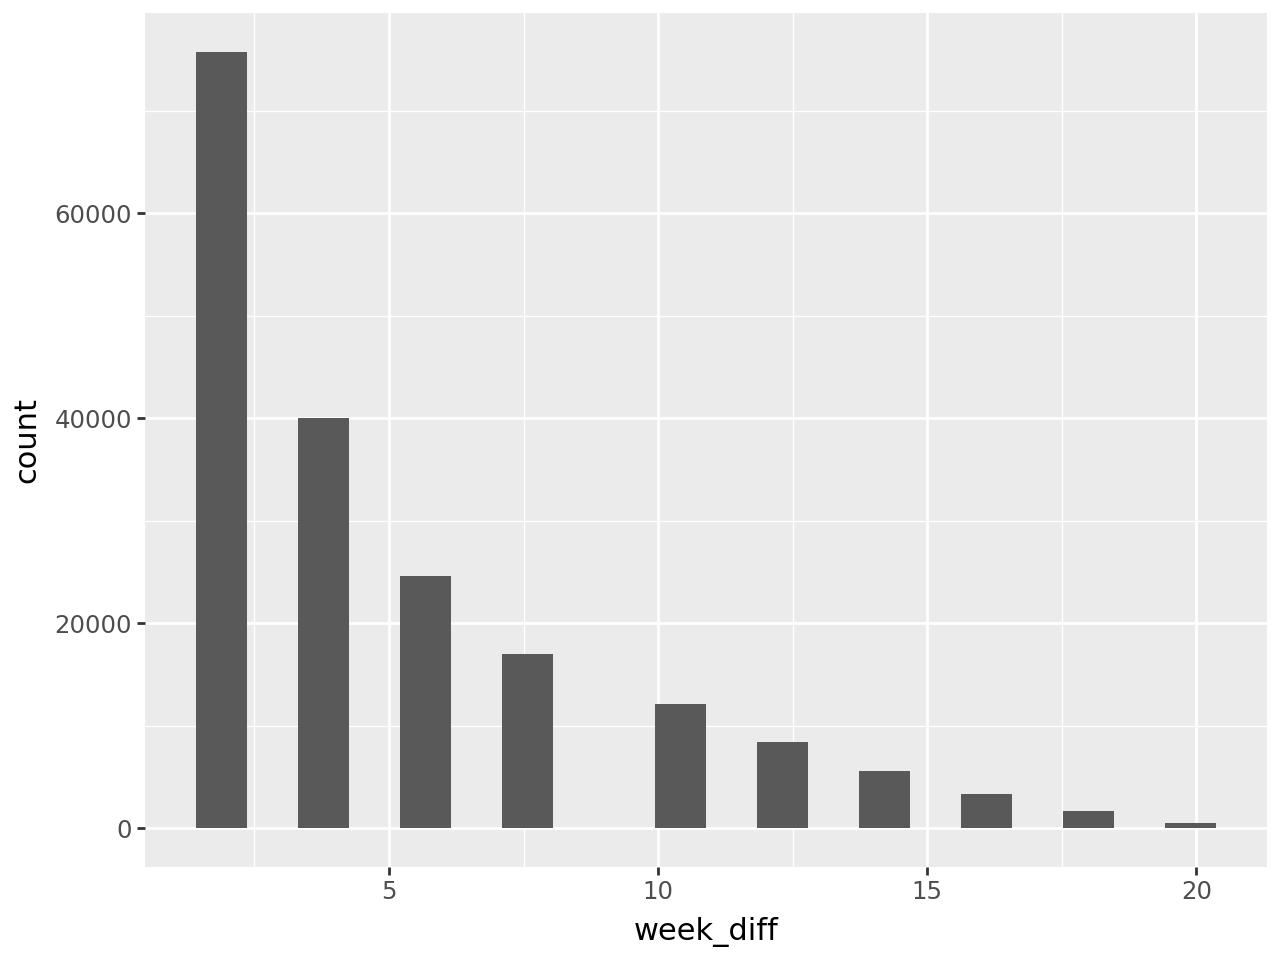

In [29]:
p9.ggplot(buy_client_2weekly.select("week_diff").drop_nulls().to_pandas(),p9.aes(x="week_diff"))+p9.geom_histogram(bins=20)

In [20]:
buy_client_2weekly.describe(percentiles=[0.1,.25,.5,.75,.9,.95,.99])

statistic,client_id,week2,len,week2_p1,week_diff
str,f64,str,f64,str,f64
"""count""",940209.0,"""940209""",940209.0,"""189349""",189349.0
"""null_count""",0.0,"""0""",0.0,"""750860""",750860.0
"""mean""",1.1945e7,"""2022-07-25 22:08:05.914000""",1.789279,"""2022-07-08 14:52:05.390000""",5.239573
"""std""",6.8886e6,null,2.247907,null,3.891879
"""min""",14.0,"""2022-05-16 00:00:00""",1.0,"""2022-05-16 00:00:00""",2.0
…,…,…,…,…,…
"""75%""",1.7906976e7,"""2022-09-05 00:00:00""",2.0,"""2022-08-08 00:00:00""",8.0
"""90%""",2.1498481e7,"""2022-09-19 00:00:00""",3.0,"""2022-09-05 00:00:00""",12.0
"""95%""",2.2684651e7,"""2022-10-03 00:00:00""",4.0,"""2022-09-05 00:00:00""",14.0


In [30]:
750860.0/(750860.0+189349.)

0.7986096708285073

80% only have a single purchase
of the 20%, 75% have next purchase within 4 intervals (8 weeks)

In [27]:
buy_2weekly.group_by("week2","client_id").agg(pl.col("sku").n_unique()).describe(percentiles=[0.1,.25,.5,.75,.9,.95,.99])

statistic,week2,client_id,sku
str,str,f64,f64
"""count""","""940209""",940209.0,940209.0
"""null_count""","""0""",0.0,0.0
"""mean""","""2022-07-25 22:08:05.914000""",1.1945e7,1.470417
"""std""",null,6.8886e6,1.62853
"""min""","""2022-05-16 00:00:00""",14.0,1.0
"""10%""","""2022-05-30 00:00:00""",2.400914e6,1.0
"""25%""","""2022-06-13 00:00:00""",5.97761e6,1.0
"""50%""","""2022-07-25 00:00:00""",1.1940441e7,1.0
"""75%""","""2022-09-05 00:00:00""",1.7906976e7,1.0


1. buy 2 weekly
2. drop extra skus
3. client_id | week | sku / 0 | price/0 |category
4. add end date
5. generate nulls in between
6. add lags

In [ ]:
buy_2weekly.select("client_id

In [29]:
buy_2weekly.group_by("client_id").agg(pl.col("week2").n_unique())["week2"].describe(percentiles=[0.1,.25,.5,.75,.9,.95,.99])

statistic,value
str,f64
"""count""",750860.0
"""null_count""",0.0
"""mean""",1.252176
"""std""",0.683817
"""min""",1.0
"""10%""",1.0
"""25%""",1.0
"""50%""",1.0
"""75%""",1.0


75% of client-weeks and client-2 weeks have only a single sku.
and 99% of clients have only 4 weeks

In [34]:
# do we have to sort by for each column
aa = (
    buy
    .sort("timestamp")
    .group_by("client_id")
    .agg(n_buy=pl.len(), 
         timestamps = pl.col("timestamp"),
         skus=pl.col("sku")
    )
)
aa.head()

client_id,n_buy,timestamps,skus
i64,u32,list[datetime[ms]],list[i64]
2854819,1,[2022-10-10 09:50:15],[1355828]
7210708,2,"[2022-08-25 10:15:35, 2022-08-25 10:22:15]","[1401979, 1283094]"
8928662,2,"[2022-07-01 22:05:30, 2022-07-01 22:05:30]","[231713, 231713]"
23837284,1,[2022-09-18 20:58:45],[1435562]
19238874,1,[2022-09-29 12:46:15],[148510]


In [36]:
for n_buy, clients in aa.head(50).group_by("n_buy"):
    print(n_buy, clients)
    for ix in 0:n_buy - block_size
    

(42,) shape: (1, 4)
┌───────────┬───────┬─────────────────────────────────┬─────────────────────────────┐
│ client_id ┆ n_buy ┆ timestamps                      ┆ skus                        │
│ ---       ┆ ---   ┆ ---                             ┆ ---                         │
│ i64       ┆ u32   ┆ list[datetime[ms]]              ┆ list[i64]                   │
╞═══════════╪═══════╪═════════════════════════════════╪═════════════════════════════╡
│ 13159520  ┆ 42    ┆ [2022-08-24 11:25:35, 2022-08-… ┆ [624349, 444611, … 1407176] │
└───────────┴───────┴─────────────────────────────────┴─────────────────────────────┘
(1,) shape: (25, 4)
┌───────────┬───────┬───────────────────────┬───────────┐
│ client_id ┆ n_buy ┆ timestamps            ┆ skus      │
│ ---       ┆ ---   ┆ ---                   ┆ ---       │
│ i64       ┆ u32   ┆ list[datetime[ms]]    ┆ list[i64] │
╞═══════════╪═══════╪═══════════════════════╪═══════════╡
│ 2854819   ┆ 1     ┆ [2022-10-10 09:50:15] ┆ [1355828] │
│ 23837284

In [35]:
buy.filter(pl.col("client_id")==7210708)

client_id,timestamp,sku,action,category,price,name
i64,datetime[ms],i64,str,i64,i64,list[i16]
7210708,2022-08-25 10:15:35,1401979,"""product_buy""",1560,72,"[38, 250, … 112]"
7210708,2022-08-25 10:22:15,1283094,"""product_buy""",1560,68,"[194, 112, … 112]"
